In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [73]:
def aggregate_individual_data_per_day(raw=pd.DataFrame, to_average=None ):
    """
    for the raw data of one individual a new df is generated with the variables as columns. Values are summed unless their variable name is 
    specified to be averaged in to_average.

    Parameters
    ----------
    INPUT
    raw : df
        DataFrame with the raw data
    to_average : array-like
        array specifiying which variables to average

    RETURNS
    processed : df
        DataFrame wiht the processed data
    """

    # add column with date only
    raw['time'] = pd.to_datetime(raw.loc[:,'time'])
    raw['date'] = raw['time'].dt.date

    # initialize new df with variables as columns
    vars = ['date', 'mood', 'circumplex.arousal', 'circumplex.valence',
       'activity', 'screen', 'call', 'sms', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather',
       'mood_std', 'circumplex.arousal_std', 'circumplex.valence_std',
       'activity_std']
    processed = pd.DataFrame(columns= vars)

    # fill df
    # loop over days
    for i, day in enumerate(raw['date'].unique()):
        processed.loc[i, 'date'] = day
        row = (raw['date'] == day)

        # loop over variables
        for col in vars[1:-1]:

            # average values of given specified variables
            if col in to_average:
                processed.loc[i, col] = raw.loc[row & (raw['variable'] == col)].value.mean()
                processed.loc[i, col+'_std'] = raw.loc[row & (raw['variable'] == col)].value.std()

            
            # sum values for the other variables
            else:
                processed.loc[i, col] = raw.loc[row & (raw['variable'] == col)].value.abs().sum()

    # sort the df according to date
    processed['date'] = pd.to_datetime(processed.loc[:,'date'])
    processed.sort_values('date')

    processed.drop(processed.loc[processed['mood'].isna() & (processed['screen'] == 0)].index, inplace=True)

    processed.reindex()


    # # delete the first part without data
    # while np.isnan(processed.loc[0,'mood']):
    #     processed.drop(index = 0)
    #     processed.reindex()

    processed.insert(1, 'weekday', processed['date'].dt.weekday)

    return processed

def aggregate_individual_data_per_reading(raw=pd.DataFrame, to_average=None ):
    """
    for the raw data of one individual a new df is generated with the variables as columns. Values are summed unless their variable name is 
    specified to be averaged in to_average.

    Parameters
    ----------
    INPUT
    raw : df
        DataFrame with the raw data
    to_average : array-like
        array specifiying which variables to average

    RETURNS
    processed : df
        DataFrame wiht the processed data
    """

    # add column with date only
    raw['time'] = pd.to_datetime(raw.loc[:,'time'])
    raw.sort_values('time')

    # initialize new df with variables as columns
    vars = ['time', 'mood', 'circumplex.arousal', 'circumplex.valence',
       'activity', 'screen', 'call', 'sms', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']
    processed = pd.DataFrame(columns = vars)

    measure_times = raw['time'].loc[raw['variable'] == 'mood']
    # add an date in the past for first measurement
    measure_times = pd.concat([pd.to_datetime(pd.Series(['2014-01-01 00:00:00.000'])), measure_times], ignore_index=True)

    # fill df
    # loop over times
    for i in range(1,len(measure_times)):
        processed.loc[i, 'time'] = measure_times[i]
        rows = (measure_times[i-1] < raw['time']) & (raw['time'] <= measure_times[i])

        # loop over variables
        for col in vars[1:-1]:

            # average values of given specified variables
            if col in to_average:
                processed.loc[i-1, col] = raw.loc[(raw['time'] == measure_times[i]) & (raw['variable'] == col)].value

            
            # sum values for the other variables
            else:
                processed.loc[i-1, col] = raw.loc[rows & (raw['variable'] == col)].value.abs().sum()

    # sort the df according to date
    processed['time'] = pd.to_datetime(processed.loc[:,'date'])
    processed.sort_values('date')

    processed.drop(processed.loc[processed['mood'].isna() & (processed['screen'] == 0)].index, inplace=True)

    processed.reindex()


    # # delete the first part without data
    # while np.isnan(processed.loc[0,'mood']):
    #     processed.drop(index = 0)
    #     processed.reindex()

    processed.insert(1, 'weekday', processed['date'].dt.weekday)

    return processed

In [32]:
raw_data = pd.read_csv('data/dataset_mood_smartphone.csv')

In [33]:
raw_data.head()

,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.0
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.0
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.0
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.0
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.0


In [34]:
# cast id to integers
unique_ids = raw_data['id'].unique()
new_ids = np.arange(0,27,1)
raw_data['id'] = raw_data['id'].replace(unique_ids, new_ids)
raw_data.head()

,Unnamed: 0,id,time,variable,value
0,1,0,2014-02-26 13:00:00.000,mood,6.0
1,2,0,2014-02-26 15:00:00.000,mood,6.0
2,3,0,2014-02-26 18:00:00.000,mood,6.0
3,4,0,2014-02-26 21:00:00.000,mood,7.0
4,5,0,2014-02-27 09:00:00.000,mood,6.0


In [35]:
# specify variables to average
to_average = np.array(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity'])

# process df for each individual
processed_dfs = []
for i in tqdm(new_ids):
    raw_df = raw_data.loc[raw_data['id'] == i].copy()
    processed_df = aggregate_individual_data_per_day(raw_df, to_average)
    processed_dfs.append(processed_df)
    processed_df.to_csv('aggregated_individual_data/'+str(i)+'_aggregated.csv')

100%|██████████| 27/27 [00:32<00:00,  1.21s/it]


In [7]:
processed_dfs[0].tail()

,date,weekday,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,...,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather
44,2014-05-02,4,7.6,-0.2,1.0,0.077341,15088.519001,0.0,0.0,795.436,...,352.888,1069.748,0.0,0.0,32.443,771.266,0.0,0.0,11.083,NaN
45,2014-05-03,5,8.0,-0.2,1.0,0.071741,8186.036001,0.0,1.0,753.257,...,2761.95,296.313,0.0,0.0,40.569,205.602,143.631,30.102,125.605,NaN
46,2014-05-04,6,8.0,-0.5,1.0,0.136192,5889.194999,0.0,0.0,1758.438,...,928.406,0.0,0.0,0.0,35.525,494.677,0.0,0.0,0.0,NaN
47,2014-03-20,3,NaN,NaN,NaN,0.081548,2275.944,1.0,0.0,248.979,...,350.856,0.0,0.0,0.0,11.345,807.731,0.0,45.173,21.074,NaN
48,2014-05-05,0,NaN,NaN,NaN,0.007843,1788.734,0.0,0.0,438.347,...,318.514,0.0,0.0,0.0,0.0,25.104,0.0,0.0,264.331,NaN


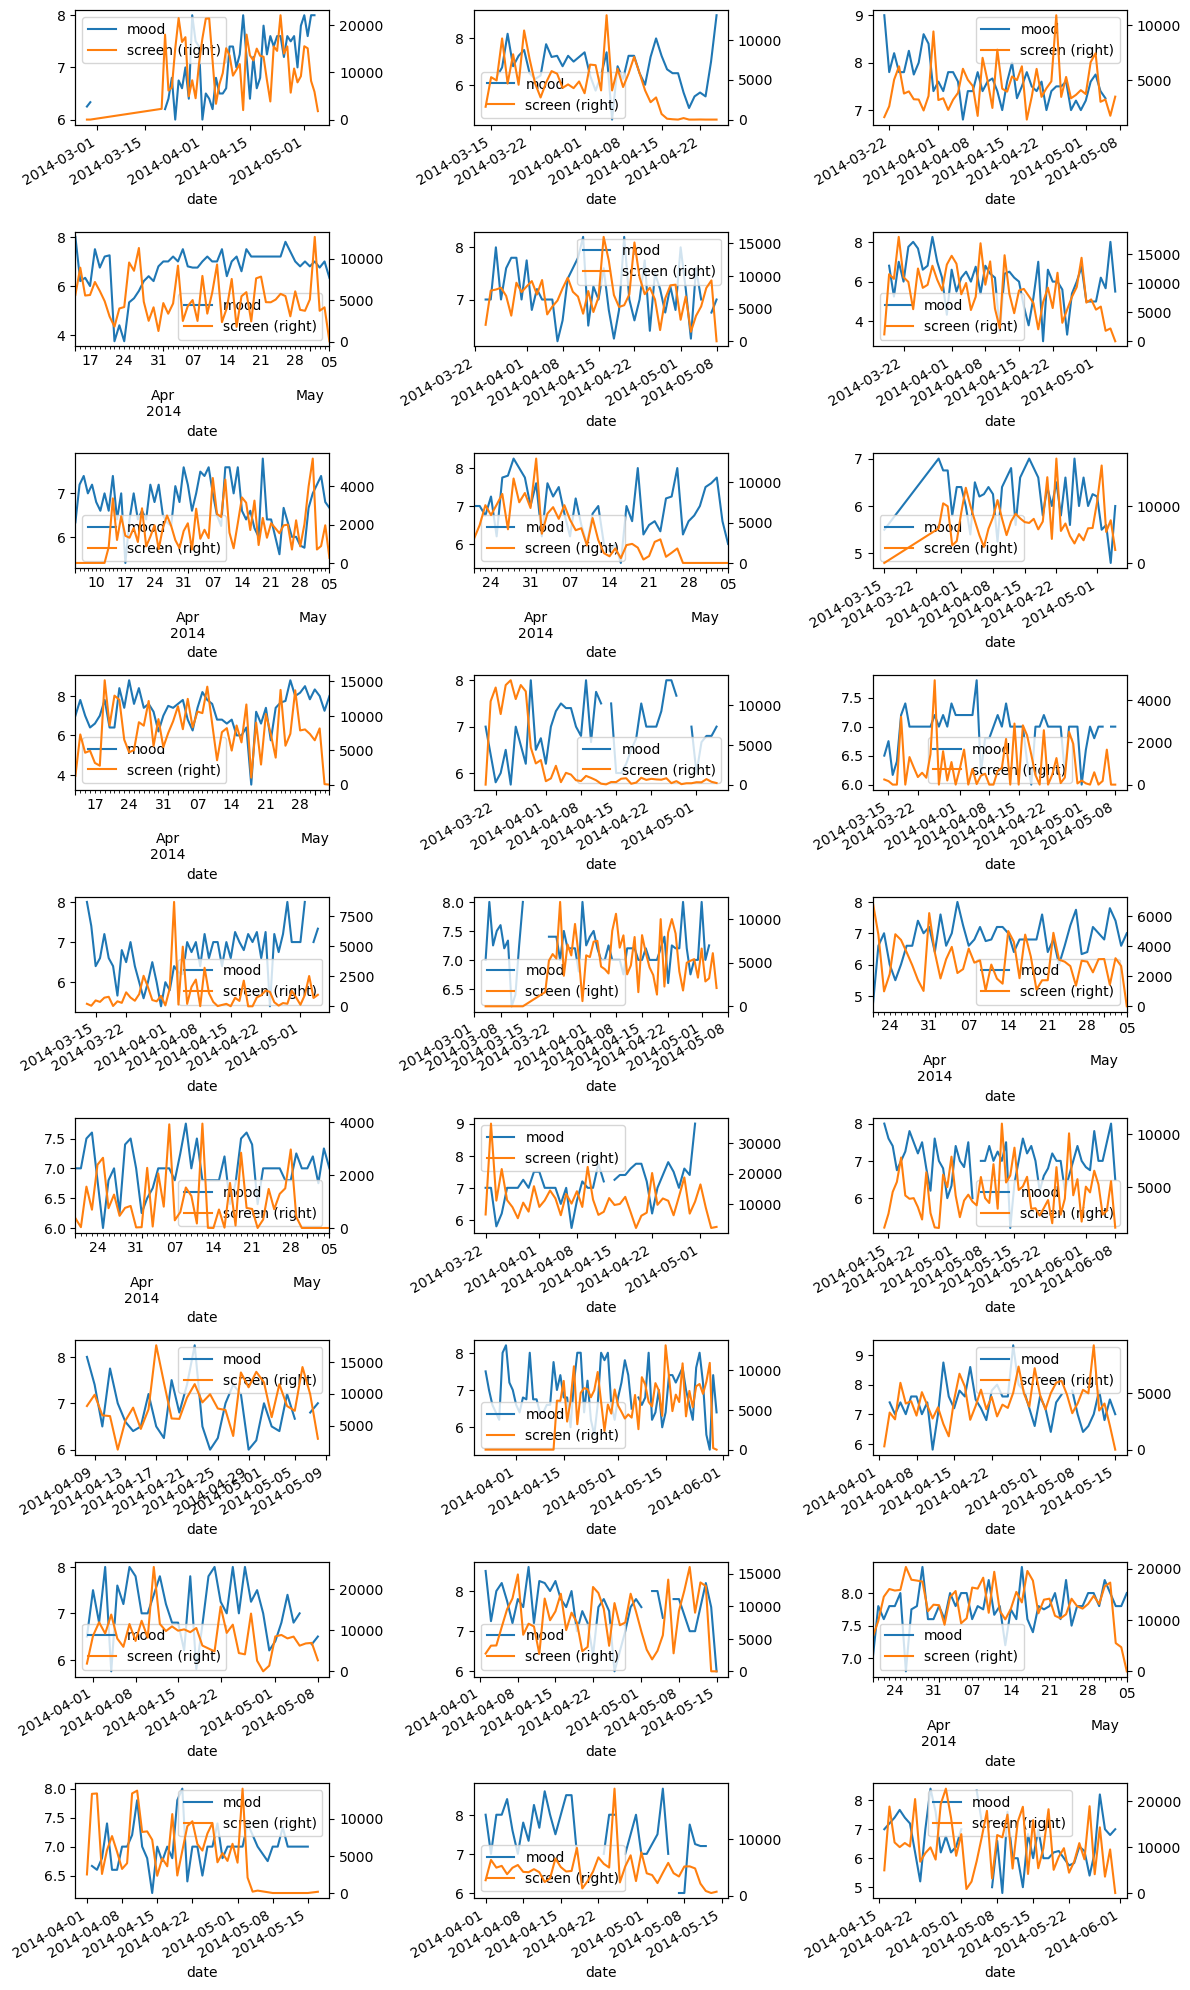

In [22]:
# plot some data
nrows = 9
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize = [12, 20])

counter = 0
for row in range(nrows):
    for col in range(ncols):
        processed_dfs[counter].plot('date', 'mood', ax = axes[row, col])
        processed_dfs[counter].plot('date', 'screen', ax = axes[row, col], secondary_y=True)
        counter += 1

        if counter >= len(processed_dfs):
            break
    if counter >= len(processed_dfs):
            break
    
plt.tight_layout()

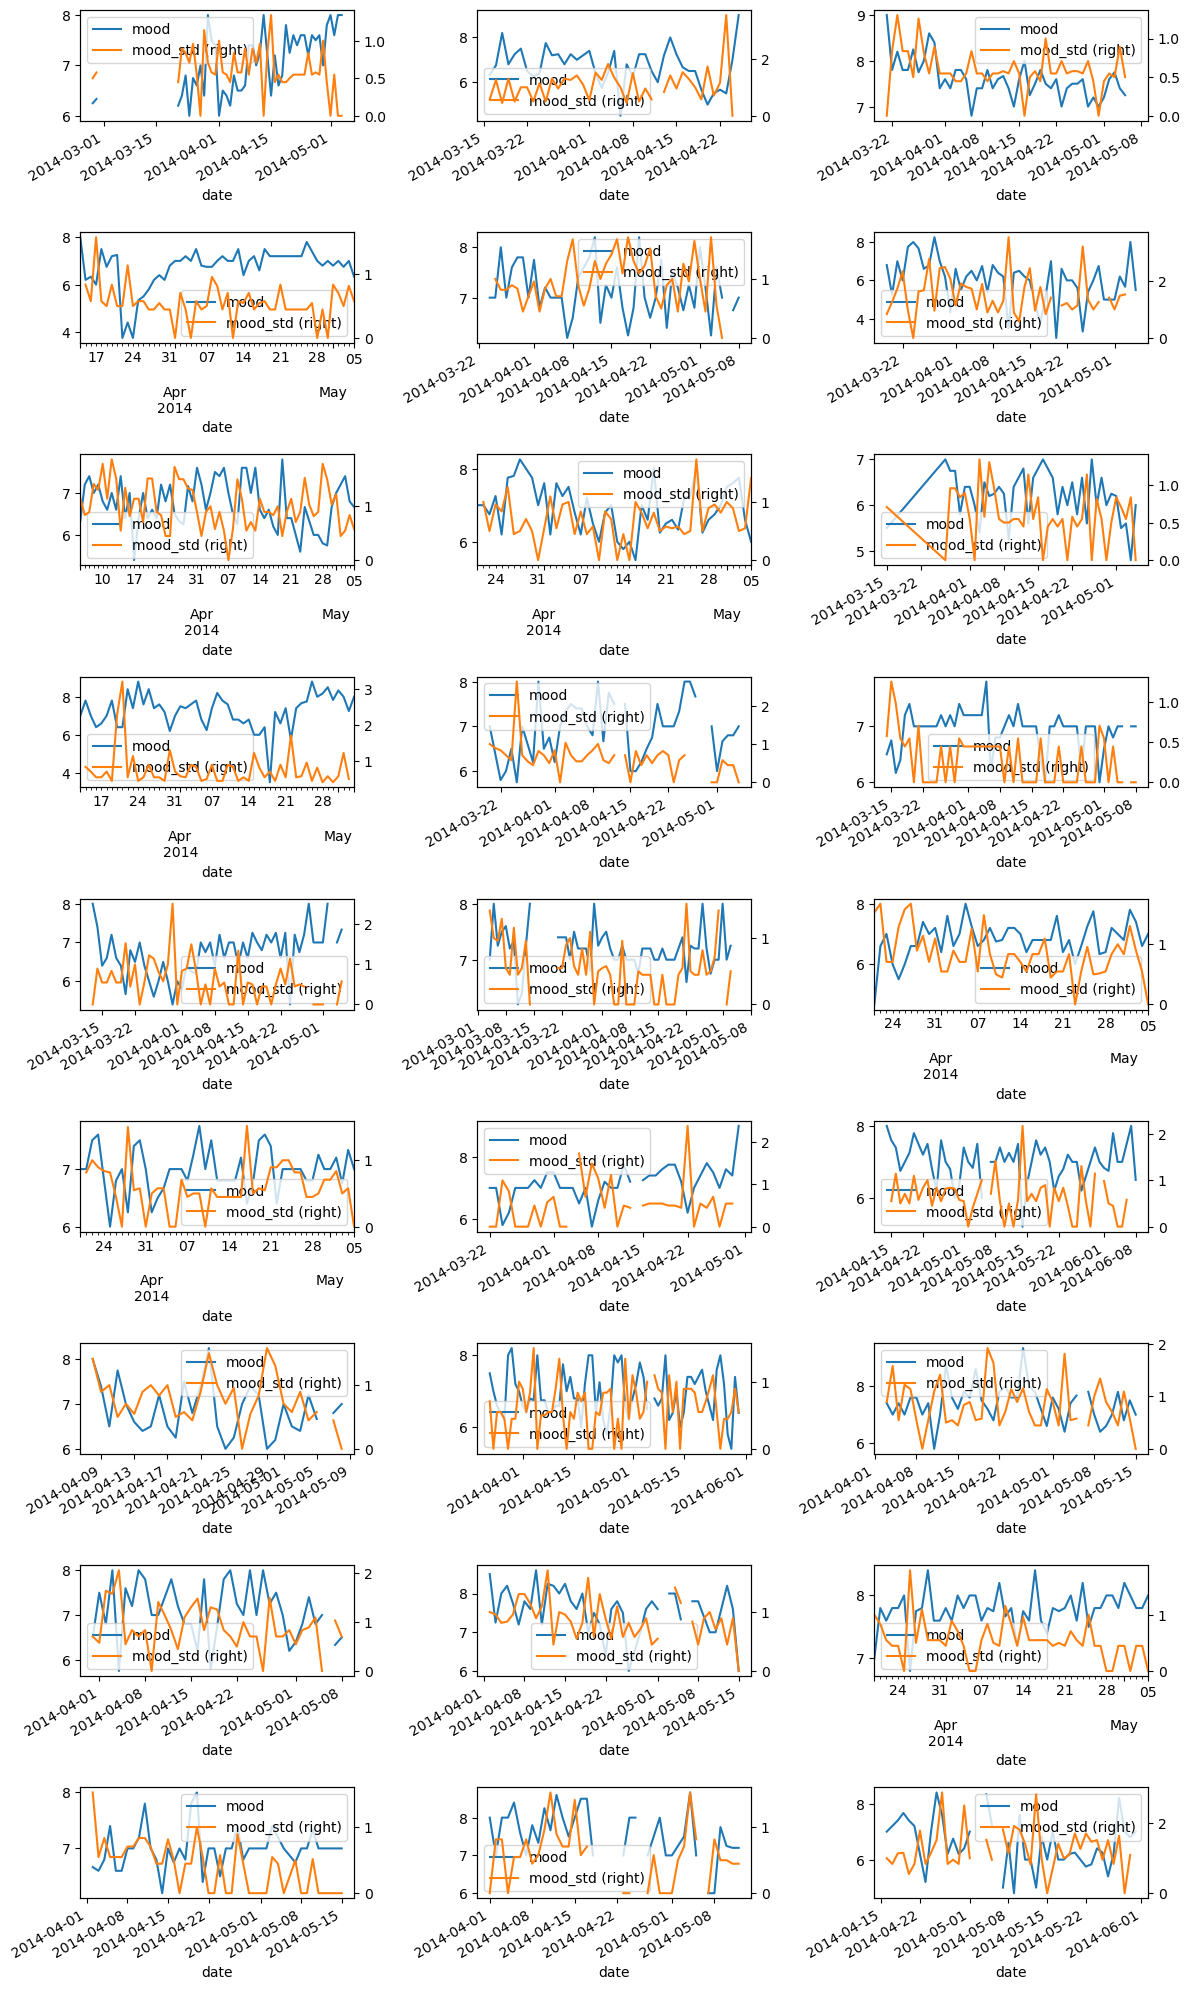

In [23]:
# plot some data
nrows = 9
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize = [12, 20])

counter = 0
for row in range(nrows):
    for col in range(ncols):
        processed_dfs[counter].plot('date', 'mood', ax = axes[row, col])
        processed_dfs[counter].plot('date', 'mood_std', ax = axes[row, col], secondary_y=True)
        counter += 1

        if counter >= len(processed_dfs):
            break
    if counter >= len(processed_dfs):
            break
    
plt.tight_layout()

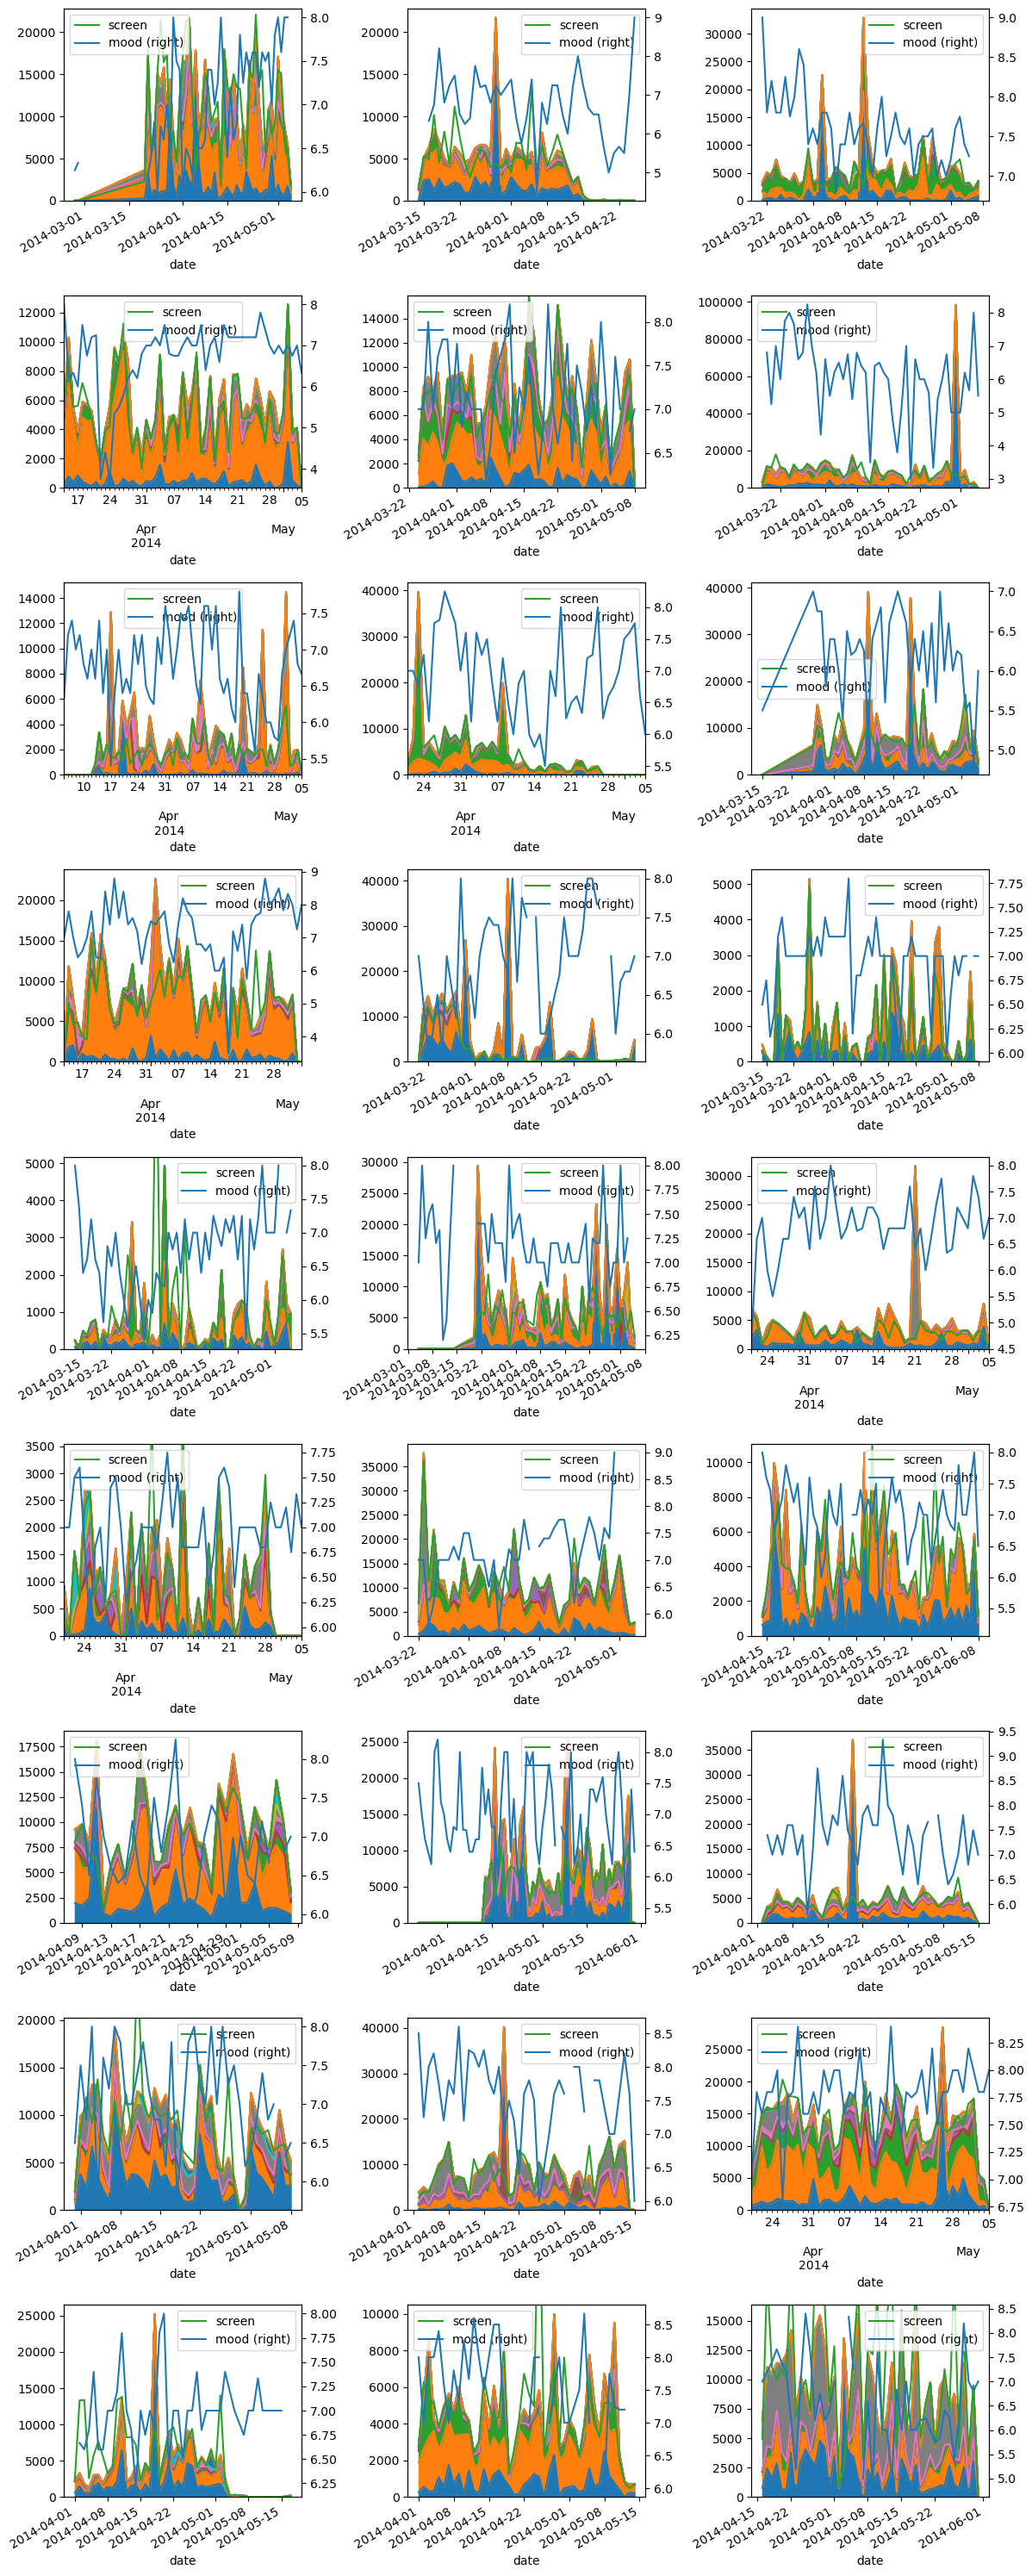

In [45]:
# plot some data
nrows = 9
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize = [12, 30])

counter = 0
for row in range(nrows):
    for col in range(ncols):
        processed_dfs[counter].plot.area('date', ['appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather'], ax = axes[row, col])
        axes[row, col].get_legend().remove()

        processed_dfs[counter].plot('date', 'screen', ax = axes[row, col])
        processed_dfs[counter].plot('date', 'mood', ax = axes[row, col], secondary_y=True, color = 'C0')
        counter += 1

        
        #axes[row, col].set_ylim([5,9])

        if counter >= len(processed_dfs):
            break
    if counter >= len(processed_dfs):
            break
    
plt.tight_layout()

In [24]:
processed_dfs[0].columns

Index(['date', 'weekday', 'mood', 'circumplex.arousal', 'circumplex.valence',
       'activity', 'screen', 'call', 'sms', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather',
       'mood_std', 'circumplex.arousal_std', 'circumplex.valence_std',
       'activity_std'],
      dtype='object')

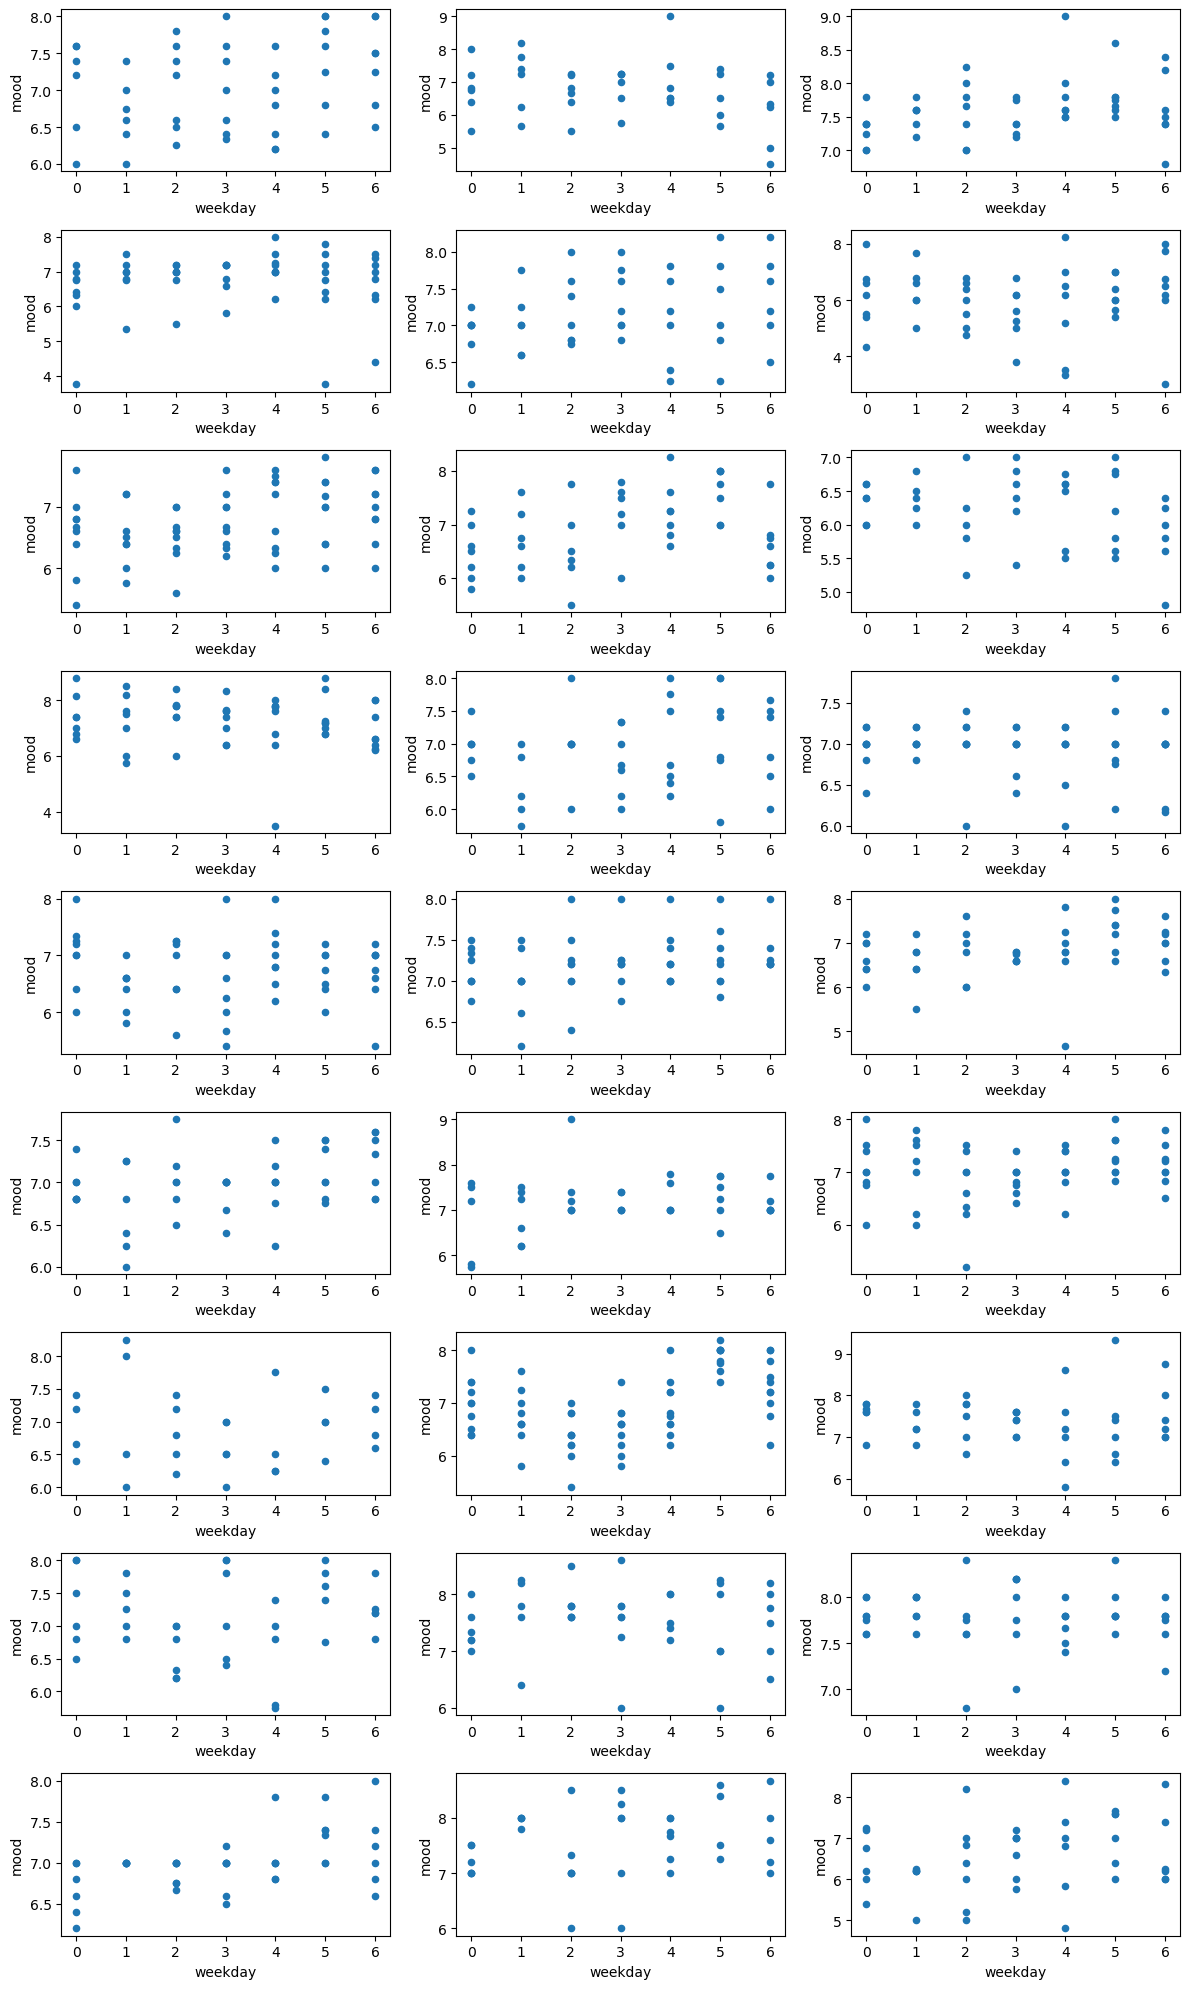

In [9]:
# plot some data
nrows = 9
ncols = 3

fig, axes = plt.subplots(nrows, ncols, figsize = [12, 20])

counter = 0
for row in range(nrows):
    for col in range(ncols):
        processed_dfs[counter].plot.scatter('weekday', 'mood', ax = axes[row, col])
        #processed_dfs[counter].plot('date', 'screen', ax = axes[row, col], secondary_y=True)
        counter += 1

        if counter >= len(processed_dfs):
            break
    if counter >= len(processed_dfs):
            break
    
plt.tight_layout()

In [74]:
# specify variables to average
to_average = np.array(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity'])

# process df for each individual
processed_dfs_measure = []
for i in tqdm(new_ids):
    raw_df = raw_data.loc[raw_data['id'] == i].copy()
    processed_df = aggregate_individual_data_per_reading(raw_df, to_average)
    processed_dfs_measure.append(processed_df)
    processed_df.to_csv('aggregated_individual_data_per_measurement/'+str(i)+'_aggregated.csv')

  0%|          | 0/27 [00:00<?, ?it/s]


ValueError: Incompatible indexer with Series